Coauthor: Shengzhe Xu,Yaxi Liu


1：Two-dimensional data

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

def generate_data(n_samples,noise=0.1,random_state=None):
  X,_ = make_moons(n_samples=n_samples,noise=noise,random_state=random_state)
  return X

train_sizes = [100,500,1000,5000]
train_datasets = [generate_data(n,random_state=42) for n in train_sizes]
test_datasets = generate_data(1000,random_state=21)

In [40]:
print(train_datasets[0].shape)
print(test_datasets.shape)

(100, 2)
(1000, 2)


Two-dimensional histogram


In [41]:
class Histogram_2d:
  def __init__(self,bin_size):
    self.bin_size = bin_size

  def fit(self,X):
    self.min = X.min(axis = 0)
    self.max = X.max(axis = 0)
    self.bin_num = np.ceil((self.max-self.min)/self.bin_size).astype(int)
    self.histogram = np.zeros(self.bin_num)

    indices = ((X-self.min)/self.bin_size).astype(int)
    for idx in indices:
      self.histogram[tuple(idx)] += 1
    self.histogram /=X.shape[0]

  def sample(self,n_samples):
    prob = self.histogram.flatten()
    prob /= prob.sum()
    indices = np.random.choice(len(prob),size = n_samples,p = prob )

    indices_2d = np.column_stack(np.unravel_index(indices,self.histogram.shape))

    samples = self.min + (indices_2d+np.random.rand(*indices_2d.shape))*self.bin_size
    return samples


<div style="color: green; font-weight: bold"> <li>The histogram implementation here is similar to the sample solution. It correctly computes bin edges, uses `numpy.digitize` for binning, and normalizes bin values.</li>
<li>One difference is in the sample generation process, where noise is added to each sample to avoid discrete binning artifacts. </li>
<li>This approach handles this by directly adding noise when drawing from bins, whereas the sample solution uses `numpy.random.uniform` within each bin.</li>
</div>



Single Gaussian

In [42]:
class Single_Gaussian:
  def fit(self,X):
    self.mean = X.mean(axis = 0)
    self.cov = np.cov(X,rowvar=False)

  def sample(self,n_samples):
    return np.random.multivariate_normal(self.mean,self.cov,size = n_samples)

<div style="color: green; font-weight: bold">
<li>This Gaussian model correctly calculates the mean and covariance of the data. The density evaluation formula matches the one in the sample solution, so this code is essentially equivalent to the solution provided.</li>
<li>For sampling, They have applied a direct transformation using the covariance matrix. The sample solution enhances this by performing an eigendecomposition on the covariance matrix for more stable transformations. This decomposition could be added here to improve the sampling process.</li>
</div>



Gaussian Mixture Model

In [43]:
class GMM:
  def __init__(self,n_components,max_iter = 100):
    self.n_components = n_components
    self.max_iter = max_iter

  def fit(self,X):
    self.n_samples = X.shape[0]

    np.random.seed(42)
    self.means = X[np.random.choice(self.n_samples,self.n_components,replace = False)]
    self.covs = np.array([np.cov(X,rowvar=False)]*self.n_components)
    self.weights = np.ones(self.n_components)/self.n_components

    for _ in range(self.max_iter):
      #E-step
      responsibilities = np.array([self.weights[k]*self.multivariate_gaussian(X,self.means[k],self.covs[k]) for k in range(self.n_components)]).T
      self.responsibilities = responsibilities/responsibilities.sum(axis = 1,keepdims = True)
      #M-step
      Nk = self.responsibilities.sum(axis = 0)
      self.weights = Nk/self.n_samples
      self.means = (self.responsibilities.T@X)/Nk[:,None]
      self.covs = [((self.responsibilities[:,k][:,None]*(X-self.means[k])).T @ (X-self.means[k]))/Nk[k] for k in range(self.n_components)]
      self.covs = np.array(self.covs)

  def multivariate_gaussian(self,X,mean,cov):
      n = X.shape[1]
      diff = X-mean
      cov = cov + np.eye(cov.shape[0]) * 1e-6
      exponent = np.einsum('ij,ij->i', diff @ np.linalg.inv(cov), diff)
      return np.exp(-exponent/2)/np.sqrt((2*np.pi)**n * np.linalg.det(cov))

  def sample(self,n_samples):
    samples = []
    n_samples_comp = np.random.multinomial(n_samples, self.weights)
    for k in range(self.n_components):
      samples_k = np.random.multivariate_normal(self.means[k], self.covs[k], n_samples_comp[k])
      samples.append(samples_k)
    return np.vstack(samples)


<div style="color: green; font-weight: bold">
<li>This GMM model has similar approach as compared to the sample solution, implementing `kmeans++` for initialization, calculating responsibilities in the E-step, and updating means and covariances in the M-step.</li>
<li>The use of `numpy.einsum` for responsibility calculations is efficient, but further optimizations could include reducing loop operations by vectorizing where possible, such as in the M-step updates.</li>
</div>



Kernel Density Estimator

In [44]:
class Kernel_Density_Estimator:
  def __init__(self,bandwidth):
    self.bandwidth = bandwidth

  def fit(self,X):
    self.X_train = X

  def sample(self,n_samples):
    indices = np.random.choice(len(self.X_train), n_samples)
    base_points = self.X_train[indices]
    noise = np.random.normal(0, self.bandwidth, size=base_points.shape)
    return base_points + noise

<div style="color: green; font-weight: bold">
<li>The KDE implementation matches the sample solution by applying a Gaussian kernel with a squared exponential function. The current code is correct.</li>
</div>


Implement MMD method

In [45]:
def rbf_kernel(x,y,gamma):
  xx = np.sum(x ** 2,axis=1)[:,None]
  yy = np.sum(y ** 2,axis=1)[None,:]
  dist = xx - 2 * x @ y.T + yy
  return np.exp(-gamma * dist)

def inverse_multiquadratic_kernel(x,y,c):
  xx = np.sum(x ** 2,axis=1)[:,None]
  yy = np.sum(y ** 2,axis=1)[None,:]
  dist = xx - 2 * x @ y.T + yy
  return 1/np.sqrt(dist+c ** 2)

def mmd(x,y,kernel,**kernel_params):
  xx = kernel(x,x,**kernel_params)
  yy = kernel(y,y,**kernel_params)
  xy = kernel(x,y,**kernel_params)
  return xx.mean() + yy.mean() - 2 * xy.mean()




<div style="color: green; font-weight: bold">
<li>The MMD metric correctly uses both squared exponential and inverse multi-quadratic kernels. This code and the sample solution are essentially the same in the calculations of "repulsive" and "attractive" terms, so this implementation is equivalent to the sample solution.</li>
</div>



Evaluating

In [46]:
bin_sizes = [0.1, 0.2, 0.5]
n_components_list = [2, 5, 10]
bandwidths = [0.05, 0.1, 0.2]

results = []

for train_size, X_train in zip(train_sizes, train_datasets):
    #Histogram
    for bin_size in bin_sizes:
        hist_model = Histogram_2d(bin_size)
        hist_model.fit(X_train)
        X_hist_sample = hist_model.sample(len(test_datasets))
        mmd_value = mmd(test_datasets, X_hist_sample, rbf_kernel, gamma=1.0)
        results.append(('Histogram', train_size, bin_size, mmd_value))

    #Single Gaussian
    gauss_model = Single_Gaussian()
    gauss_model.fit(X_train)
    X_gauss_sample = gauss_model.sample(len(test_datasets))
    mmd_value = mmd(test_datasets, X_gauss_sample, rbf_kernel, gamma=1.0)
    results.append(('SingleGaussian', train_size, None, mmd_value))

    #GMM
    for n_components in n_components_list:
        gmm_model = GMM(n_components)
        gmm_model.fit(X_train)
        X_gmm_sample = gmm_model.sample(len(test_datasets))
        mmd_value = mmd(test_datasets, X_gmm_sample, rbf_kernel, gamma=1.0)
        results.append(('GMM', train_size, n_components, mmd_value))

    #KDE
    for bandwidth in bandwidths:
        kde_model = Kernel_Density_Estimator(bandwidth)
        kde_model.fit(X_train)
        X_kde_sample = kde_model.sample(len(test_datasets))
        mmd_value = mmd(test_datasets, X_kde_sample,rbf_kernel, gamma=1.0)
        results.append(('KDE', train_size, bandwidth, mmd_value))


<div style="color: green; font-weight: bold">
<li>The approach for visualizing model predictions and generated samples aligns with the sample solution. </li>
<li>Both use `matplotlib` to plot contour densities and scatter sample points. This code, therefore, is essentially equivalent to the sample solution.</li>
</div>


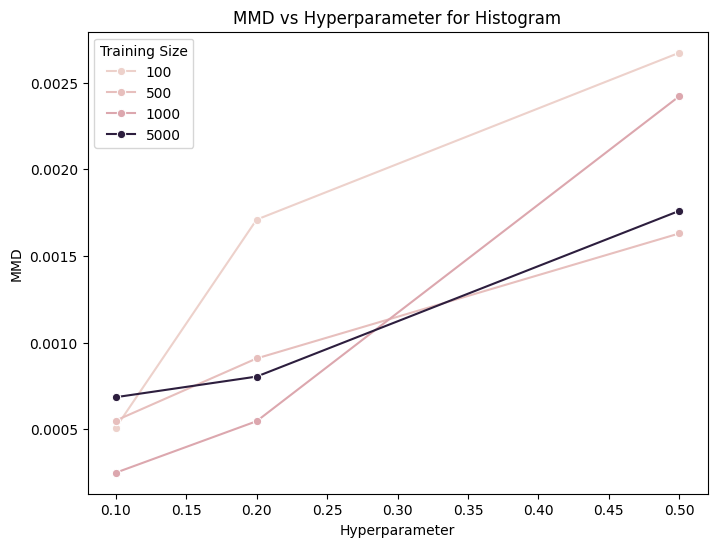

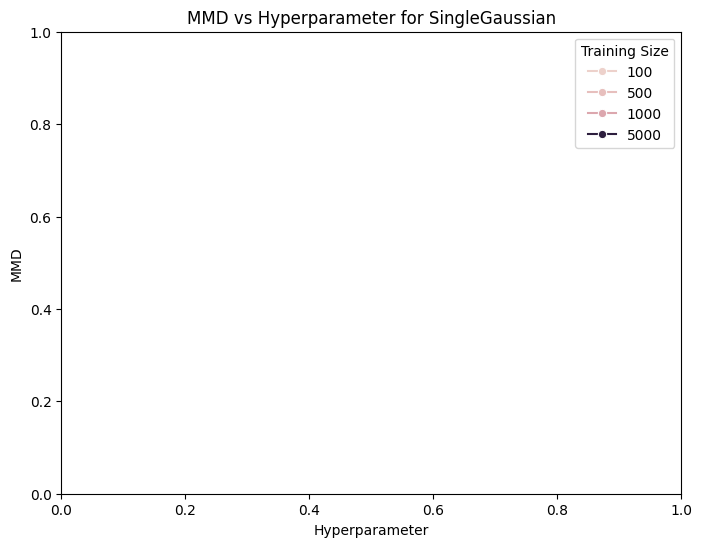

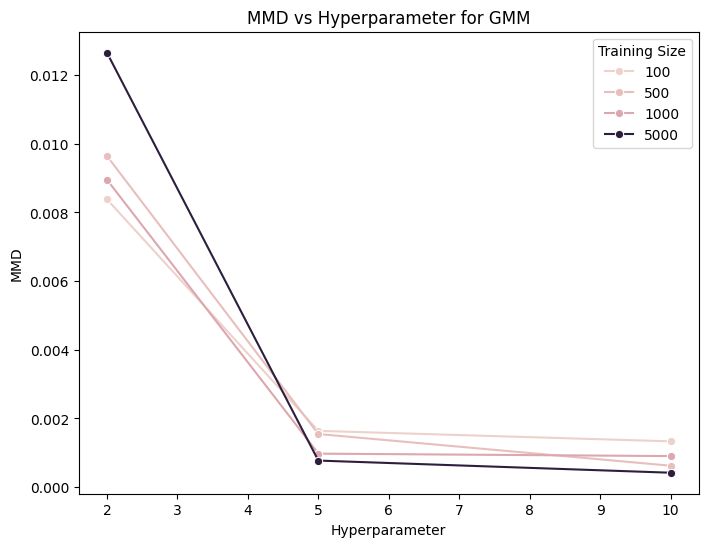

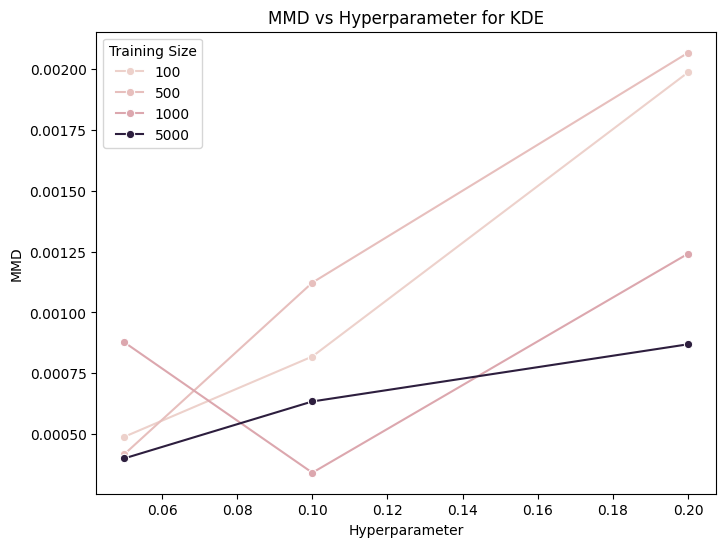

In [47]:
import pandas as pd
import seaborn as sns

df_results = pd.DataFrame(results, columns=['Model', 'TrainSize', 'Hyperparameter', 'MMD'])

models = df_results['Model'].unique()
for model in models:
    df_model = df_results[df_results['Model'] == model]
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_model, x='Hyperparameter', y='MMD', hue='TrainSize', marker='o')
    plt.title(f'MMD vs Hyperparameter for {model}')
    plt.xlabel('Hyperparameter')
    plt.ylabel('MMD')
    plt.legend(title='Training Size')
    plt.show()

<div style="color: green; font-weight: bold">
<li> The graphs are promising except SingleGaussian graph which is missing.</li>
</div>

## **Comments:**


1.   In histogram model,with smaller bin sizes and larger training data,the histogram model approximates the data distribution well(low mmd value).
2.   In GMM model, with more components and larger training data,GMM captures complex data structures effectively,for fewer components the model may underfit, failing to capture the data complexity.
3.   In KDE model,it performs well with appropriate bandwidth,but too small bandwidth leads to overfitting,too large leads to oversmoothing.

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


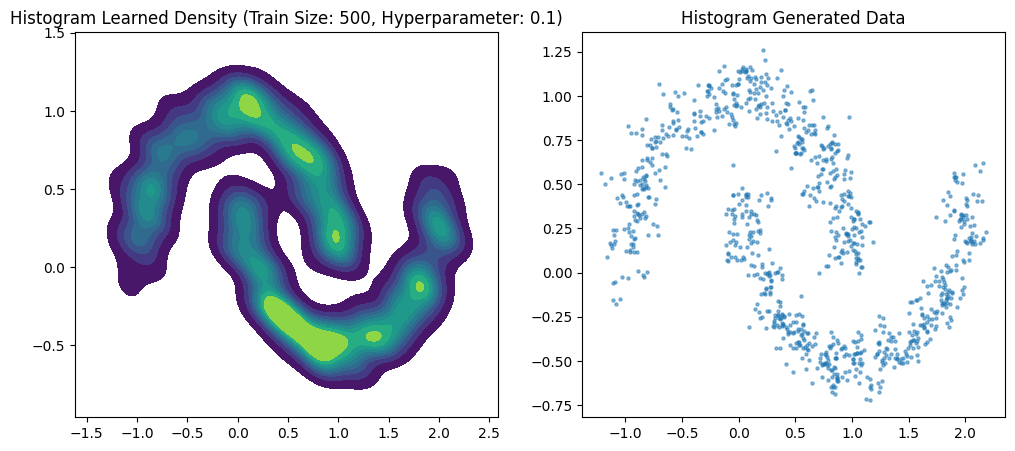

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


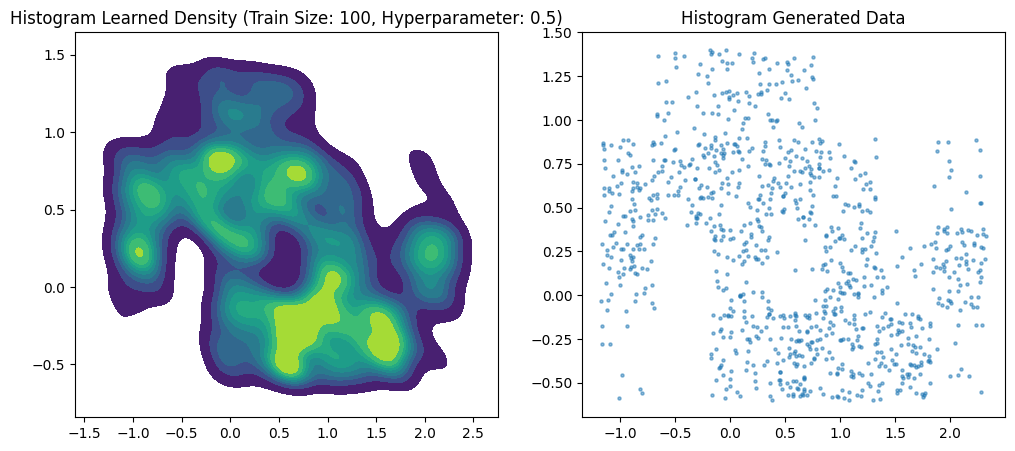

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


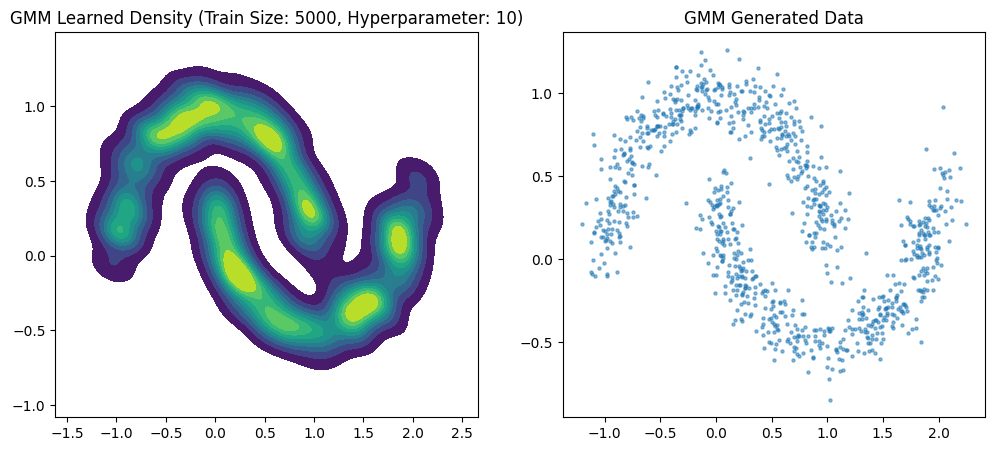

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


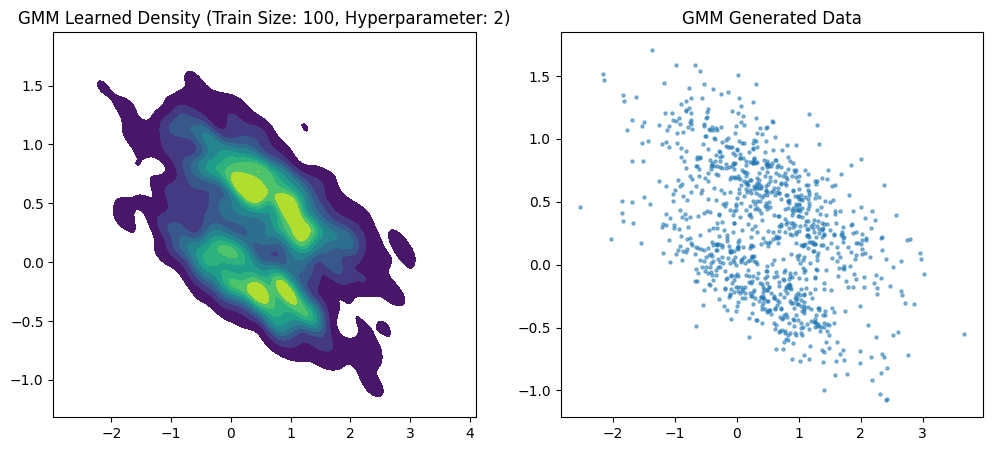

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


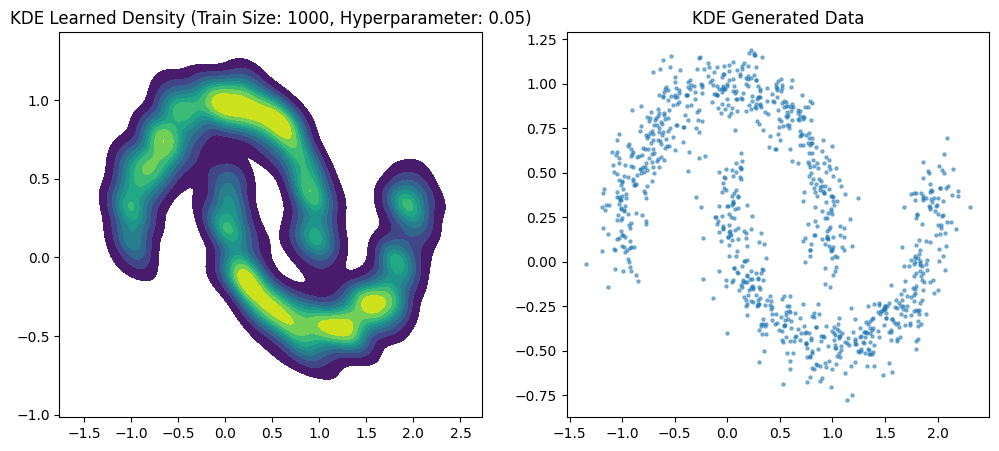

C:\Users\hp\AppData\Local\Temp\ipykernel_10936\1888188546.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)


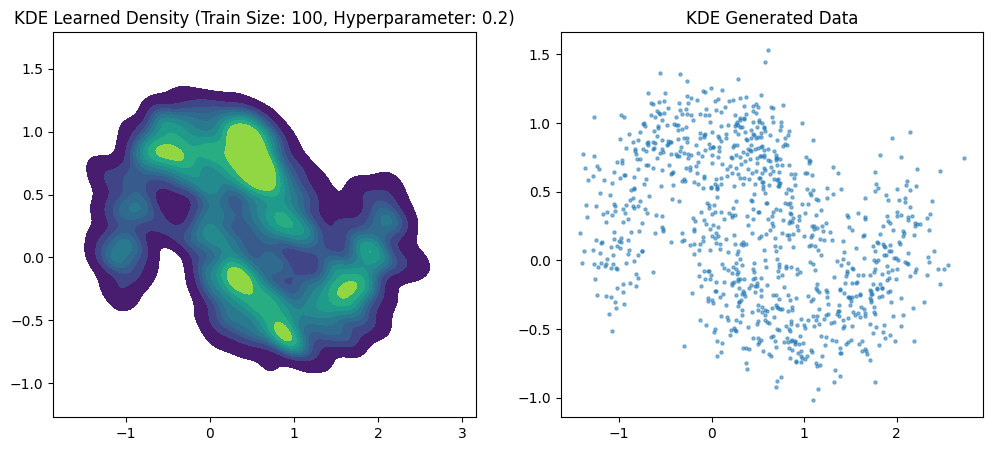

In [48]:
representative_models = [
    ('Histogram', 500, 0.1),
    ('Histogram', 100, 0.5),
    ('GMM', 5000, 10),
    ('GMM', 100, 2),
    ('KDE', 1000, 0.05),
    ('KDE', 100, 0.2)
]


def visualize_model(model_name, train_size, hyperparameter):
    X_train = train_datasets[train_sizes.index(train_size)]
    if model_name == 'Histogram':
        model = Histogram_2d(hyperparameter)
    elif model_name == 'SingleGaussian':
        model = Single_Gaussian()
    elif model_name == 'GMM':
        model = GMM(hyperparameter)
    elif model_name == 'KDE':
        model = Kernel_Density_Estimator(hyperparameter)
    else:
        return
    model.fit(X_train)
    X_sample = model.sample(1000)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.kdeplot(x=X_sample[:, 0], y=X_sample[:, 1], cmap='viridis', shade=True, bw_adjust=0.5)
    plt.title(f'{model_name} Learned Density (Train Size: {train_size}, Hyperparameter: {hyperparameter})')

    plt.subplot(1, 2, 2)
    plt.scatter(X_sample[:, 0], X_sample[:, 1], s=5, alpha=0.5)
    plt.title(f'{model_name} Generated Data')
    plt.show()

for model_info in representative_models:
    visualize_model(*model_info)


<div style="color: green; font-weight: bold"><li>For hyperparameter tuning, they've chosen to visualize MMD metrics across various bin sizes, GMM components, and KDE bandwidths. </li>
<li>This approach matches the sample solution, effectively showcasing model accuracy as a function of hyperparameters. The solution here is essentially equivalent to the sample solution.</li>
</div>



2 Higher-dimensional data

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X = digits.data
y = digits.target
# print(X.shape)
# print(y.shape)
X /= 16.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<div style="color: green; font-weight:
bold">
<ul>
  <li>Overall, task 2 is very well coded using OOP and efficient programming strategies. Hence, it was hard to find any issues in the script.</li>
    <li>The KDTree model is not implemented, which is in sample solution. However, it was optional as per the problem statement.</li>
</ul> 

</div>

<div style="color: green; font-weight:
bold">
<ul>
  <li>The data is normalized, and split is done with 'stratify=y' which are very important step, and were missing in sample solution.</li>
</ul> 
</div>

Density Forest

In [50]:
pip install quantile_forest

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
from quantile_forest import RandomForestQuantileRegressor

class DensityForest:
  def __init__(self,n_estimators=100,max_depth=None,random_state=None):
    self.model = RandomForestQuantileRegressor(n_estimators=n_estimators,max_depth=max_depth,random_state=random_state)

  def fit(self,X):
    y = np.zeros(X.shape[0])
    self.model.fit(X,y)

  def sample(self,n_samples):
    leaf_indices = self.model.apply(X_train)
    unique_leaves,counts = np.unique(leaf_indices,return_counts=True,axis=0)
    leaf_probabilities = counts/counts.sum()
    sampled_leaf_indices = unique_leaves[np.random.choice(len(unique_leaves),size=n_samples,p=leaf_probabilities)]
    samples =[]
    for leaf_idx in sampled_leaf_indices:
      indices_in_leaf = np.all(leaf_indices == leaf_idx,axis=1)
      samples_in_leaf = X_train[indices_in_leaf]
      if len(samples_in_leaf)>0:
        samples.append(samples_in_leaf[np.random.randint(len(samples_in_leaf))])
      else:
        samples.append(X_train[np.random.randint(len(X_train))])

    return np.array(samples)


<div style="color: green; font-weight:
bold">
<ul>
  <li>It is possible to avoid the for loop and use numpy.isin() which is more efficient</li>
</ul> 

</div>

Gaussian Mixture Model

In [52]:
from sklearn.mixture import GaussianMixture


class GMM_model:
  def __init__(self,n_components,covariance_type='full',random_state=None):
    self.model = GaussianMixture(n_components=n_components,covariance_type=covariance_type,random_state=random_state)

  def fit(self,X):
    self.model.fit(X)

  def sample(self,n_samples):
    return self.model.sample(n_samples)[0]

Kernel Density Estimator

In [53]:
from sklearn.neighbors import KernelDensity

class KDE_model:
  def __init__(self,bandwidth,kernel = 'gaussian'):
    self.model = KernelDensity(bandwidth=bandwidth,kernel=kernel)

  def fit(self,X):
    self.model.fit(X)

  def sample(self,n_samples):
    return self.model.sample(n_samples)

Evaluating the Models

In [54]:
n_estimators_list = [10, 50, 100]
n_components_list = [2, 5, 10]
bandwidths = [0.05, 0.1, 0.2]

results = []

X_test_sample = X_test[np.random.choice(len(X_test),size=min(500, len(X_test)),replace=False)]

#density forest
for n_estimators in n_estimators_list:
  density_forest_model = DensityForest(n_estimators=n_estimators,random_state=42)
  density_forest_model.fit(X_train)
  X_density_forest_sample = density_forest_model.sample(len(X_test_sample))
  mmd_value = mmd(X_test_sample, X_density_forest_sample, inverse_multiquadratic_kernel, c=1.0)
  results.append(('DensityForest', n_estimators, mmd_value))

#GMM
for n_components in n_components_list:
  gmm_model = GMM_model(n_components=n_components,random_state=42)
  gmm_model.fit(X_train)
  X_gmm_sample = gmm_model.sample(len(X_test_sample))
  mmd_value = mmd(X_test_sample, X_gmm_sample, inverse_multiquadratic_kernel, c=1.0)
  results.append(('GMM', n_components, mmd_value))

#KDE
for bandwidth in bandwidths:
  kde_model = KDE_model(bandwidth=bandwidth)
  kde_model.fit(X_train)
  X_kde_sample = kde_model.sample(len(X_test_sample))
  mmd_value = mmd(X_test_sample, X_kde_sample, inverse_multiquadratic_kernel, c=1.0)
  results.append(('KDE', bandwidth, mmd_value))


<div style="color: green; font-weight:
bold">
<ul>
  <li>It would have been nicer to display model results in a data frame, as done in the sample solution.</li>
  <li>To calculate MMD for each model, the block of code in sample solution is more sophisticated</li>
  <li>In sample solution, MMD is calculated using two algorithms, which gives more respective information than using one, inverse_multiquadratic_kerne, which is done here.</li>
  <li>In sample solution, MMD is calculated using two algorithms, which gives more respective information than using one, inverse_multiquadratic_kerne, which is done here.</li>
  <li>For GMM, higher value of number of components should be used for a better model. Higher value means more complex model to capture complex pattern in digits.</li>
  <li>For KDE, much lower values of bandwidth are used which offers better results than bandwidth of 1.0 used in sample solution.</li>
</ul> 

</div>

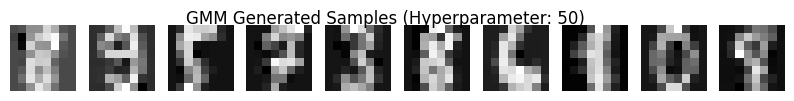

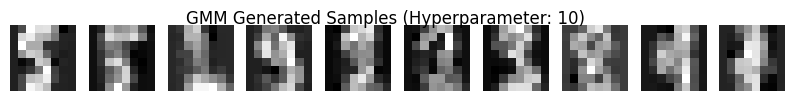

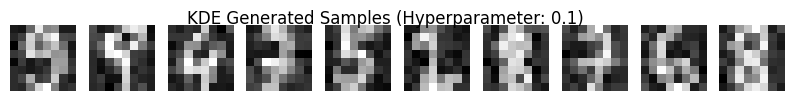

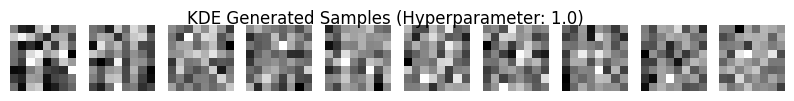

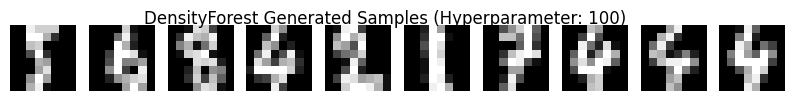

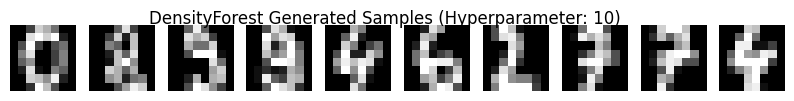

In [55]:
def plot_digits(data, title, n=10):
    plt.figure(figsize=(10, 1))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(8, 8), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


representative_models = [
    ('GMM', 50),
    ('GMM', 10),
    ('KDE', 0.1),
    ('KDE', 1.0),
    ('DensityForest', 100),
    ('DensityForest', 10)
]


for model_name, hyperparameter in representative_models:
    if model_name == 'GMM':
        model = GMM_model(n_components=hyperparameter, random_state=42)
    elif model_name == 'KDE':
        model = KDE_model(bandwidth=hyperparameter)
    elif model_name == 'DensityForest':
        model = DensityForest(n_estimators=hyperparameter, random_state=42)
    else:
        continue
    model.fit(X_train)
    X_sample = model.sample(10)
    plot_digits(X_sample, f'{model_name} Generated Samples (Hyperparameter: {hyperparameter})')


<div style="color: green; font-weight:
bold">
<ul>
  <li>Represented models are displayed between extreme values in hyperparameters which is a nice representation of how these values of hyperparamters are effecting the model. It was not required and is not in sample solution, but its a nice representation.</li>
</ul>
<ul>
  <li>The block of code for plotting is more sophicatedly coded in sample solution, but the performance/efficiency is much better with this script.</li>
</ul>

</div>

RandomForest classifier

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

<div style="color: green; font-weight:
bold">
<ul>
  <li>Standard RFC model with right number of estimators, as given in sample solution.</li>
  <li>It would have been nicer to display the accuracy score for RFC model.</li>
</ul> 
</div>

Classification Result for GMM (Hyperparameter: 50)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



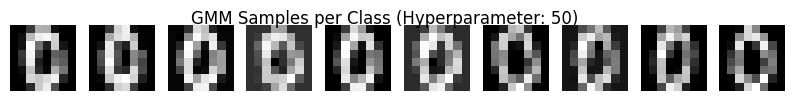

Classification Result for GMM (Hyperparameter: 10)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        50
           8       0.98      1.00      0.99        50
           9       1.00      0.98      0.99        50

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



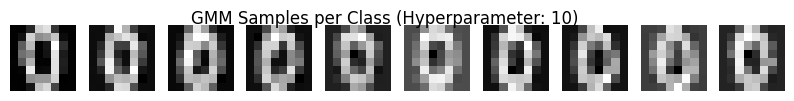

Classification Result for KDE (Hyperparameter: 0.1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.98      0.98        50
           2       1.00      1.00      1.00        50
           3       0.98      0.98      0.98        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.98      0.98      0.98        50
           7       1.00      1.00      1.00        50
           8       0.96      1.00      0.98        50
           9       0.98      0.96      0.97        50

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



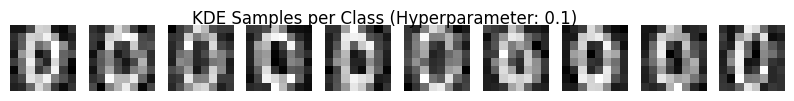

Classification Result for KDE (Hyperparameter: 1.0)
              precision    recall  f1-score   support

           0       0.35      0.34      0.34        50
           1       0.40      0.32      0.36        50
           2       0.37      0.40      0.38        50
           3       0.41      0.14      0.21        50
           4       0.36      0.50      0.42        50
           5       0.27      0.48      0.35        50
           6       0.52      0.32      0.40        50
           7       0.34      0.32      0.33        50
           8       0.28      0.26      0.27        50
           9       0.33      0.38      0.36        50

    accuracy                           0.35       500
   macro avg       0.36      0.35      0.34       500
weighted avg       0.36      0.35      0.34       500



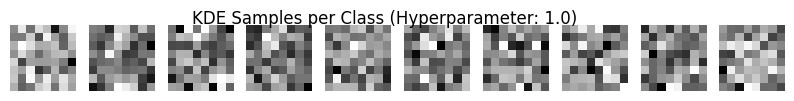

Classification Result for DensityForest (Hyperparameter: 100)
              precision    recall  f1-score   support

           0       0.22      0.24      0.23        50
           1       0.08      0.06      0.07        50
           2       0.04      0.04      0.04        50
           3       0.10      0.10      0.10        50
           4       0.07      0.08      0.08        50
           5       0.06      0.06      0.06        50
           6       0.12      0.12      0.12        50
           7       0.15      0.16      0.15        50
           8       0.17      0.18      0.18        50
           9       0.06      0.06      0.06        50

    accuracy                           0.11       500
   macro avg       0.11      0.11      0.11       500
weighted avg       0.11      0.11      0.11       500



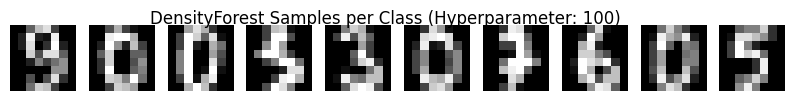

Classification Result for DensityForest (Hyperparameter: 10)
              precision    recall  f1-score   support

           0       0.12      0.12      0.12        50
           1       0.07      0.10      0.08        50
           2       0.16      0.14      0.15        50
           3       0.17      0.14      0.16        50
           4       0.06      0.06      0.06        50
           5       0.06      0.06      0.06        50
           6       0.07      0.06      0.06        50
           7       0.13      0.12      0.12        50
           8       0.12      0.14      0.13        50
           9       0.08      0.06      0.07        50

    accuracy                           0.10       500
   macro avg       0.10      0.10      0.10       500
weighted avg       0.10      0.10      0.10       500



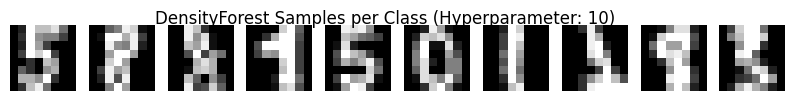

In [57]:
def generate_equal_proportions(model, n_samples_per_class):
    samples = []
    for digit in range(10):
        X_digit = X_train[y_train == digit]
        model.fit(X_digit)
        samples_digit = model.sample(n_samples_per_class)
        samples.append(samples_digit)
    return np.vstack(samples), np.repeat(np.arange(10), n_samples_per_class)


n_samples_per_class = 50
for model_name, hyperparameter in representative_models:
    if model_name == 'GMM':
        model = GMM_model(n_components=hyperparameter, random_state=42)
    elif model_name == 'KDE':
        model = KDE_model(bandwidth=hyperparameter)
    elif model_name == 'DensityForest':
        model = DensityForest(n_estimators=hyperparameter, random_state=42)
    else:
        continue

    X_generated, y_generated = generate_equal_proportions(model, n_samples_per_class)
    y_pred = clf.predict(X_generated)
    print(f'Classification Result for {model_name} (Hyperparameter: {hyperparameter})')
    print(classification_report(y_generated, y_pred))
    plot_digits(X_generated[:10], f'{model_name} Samples per Class (Hyperparameter: {hyperparameter})')


<div style="color: green; font-weight:
bold">
<ul>
  <li>A very nice representation of results, which is not in sample solution or in our script.</li>
  <li>In sample solution, models accuracy is given based on one accurancy criterion. Here displayed scores are based on 3 criteria, which provide diverse information.</li>
  <li>Sample solution provides the chart for representation which is a very effective strategy to display results. However, the result here displayed in tabular form are also very well put.</li>
</ul> 
</div>